In [9]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

10504699904
0
0


In [10]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/2023-09-09/


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [12]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), 
        ], p=1),
        A.Resize(640, 480),  # Resize every image to 640x480 after all other transformations
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [13]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [14]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the arm
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_kp')
            bboxes_labels_original.append('joint1')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')

        if self.transform:
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj):
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original  

            # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]   
#         labels = [1, 2, 3, 4]
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)


        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    

In [15]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 19410.85 files/s]


[[[257, 366]], [[257, 283]], [[232, 207]], [[252, 200]], [[216, 108]], [[203, 89]]]
0
[[257, 366]]
[257, 366]
1
[[257, 283]]
[257, 283]
2
[[232, 207]]
[232, 207]
3
[[252, 200]]
[252, 200]
4
[[216, 108]]
[216, 108]
5
[[203, 89]]
[203, 89]


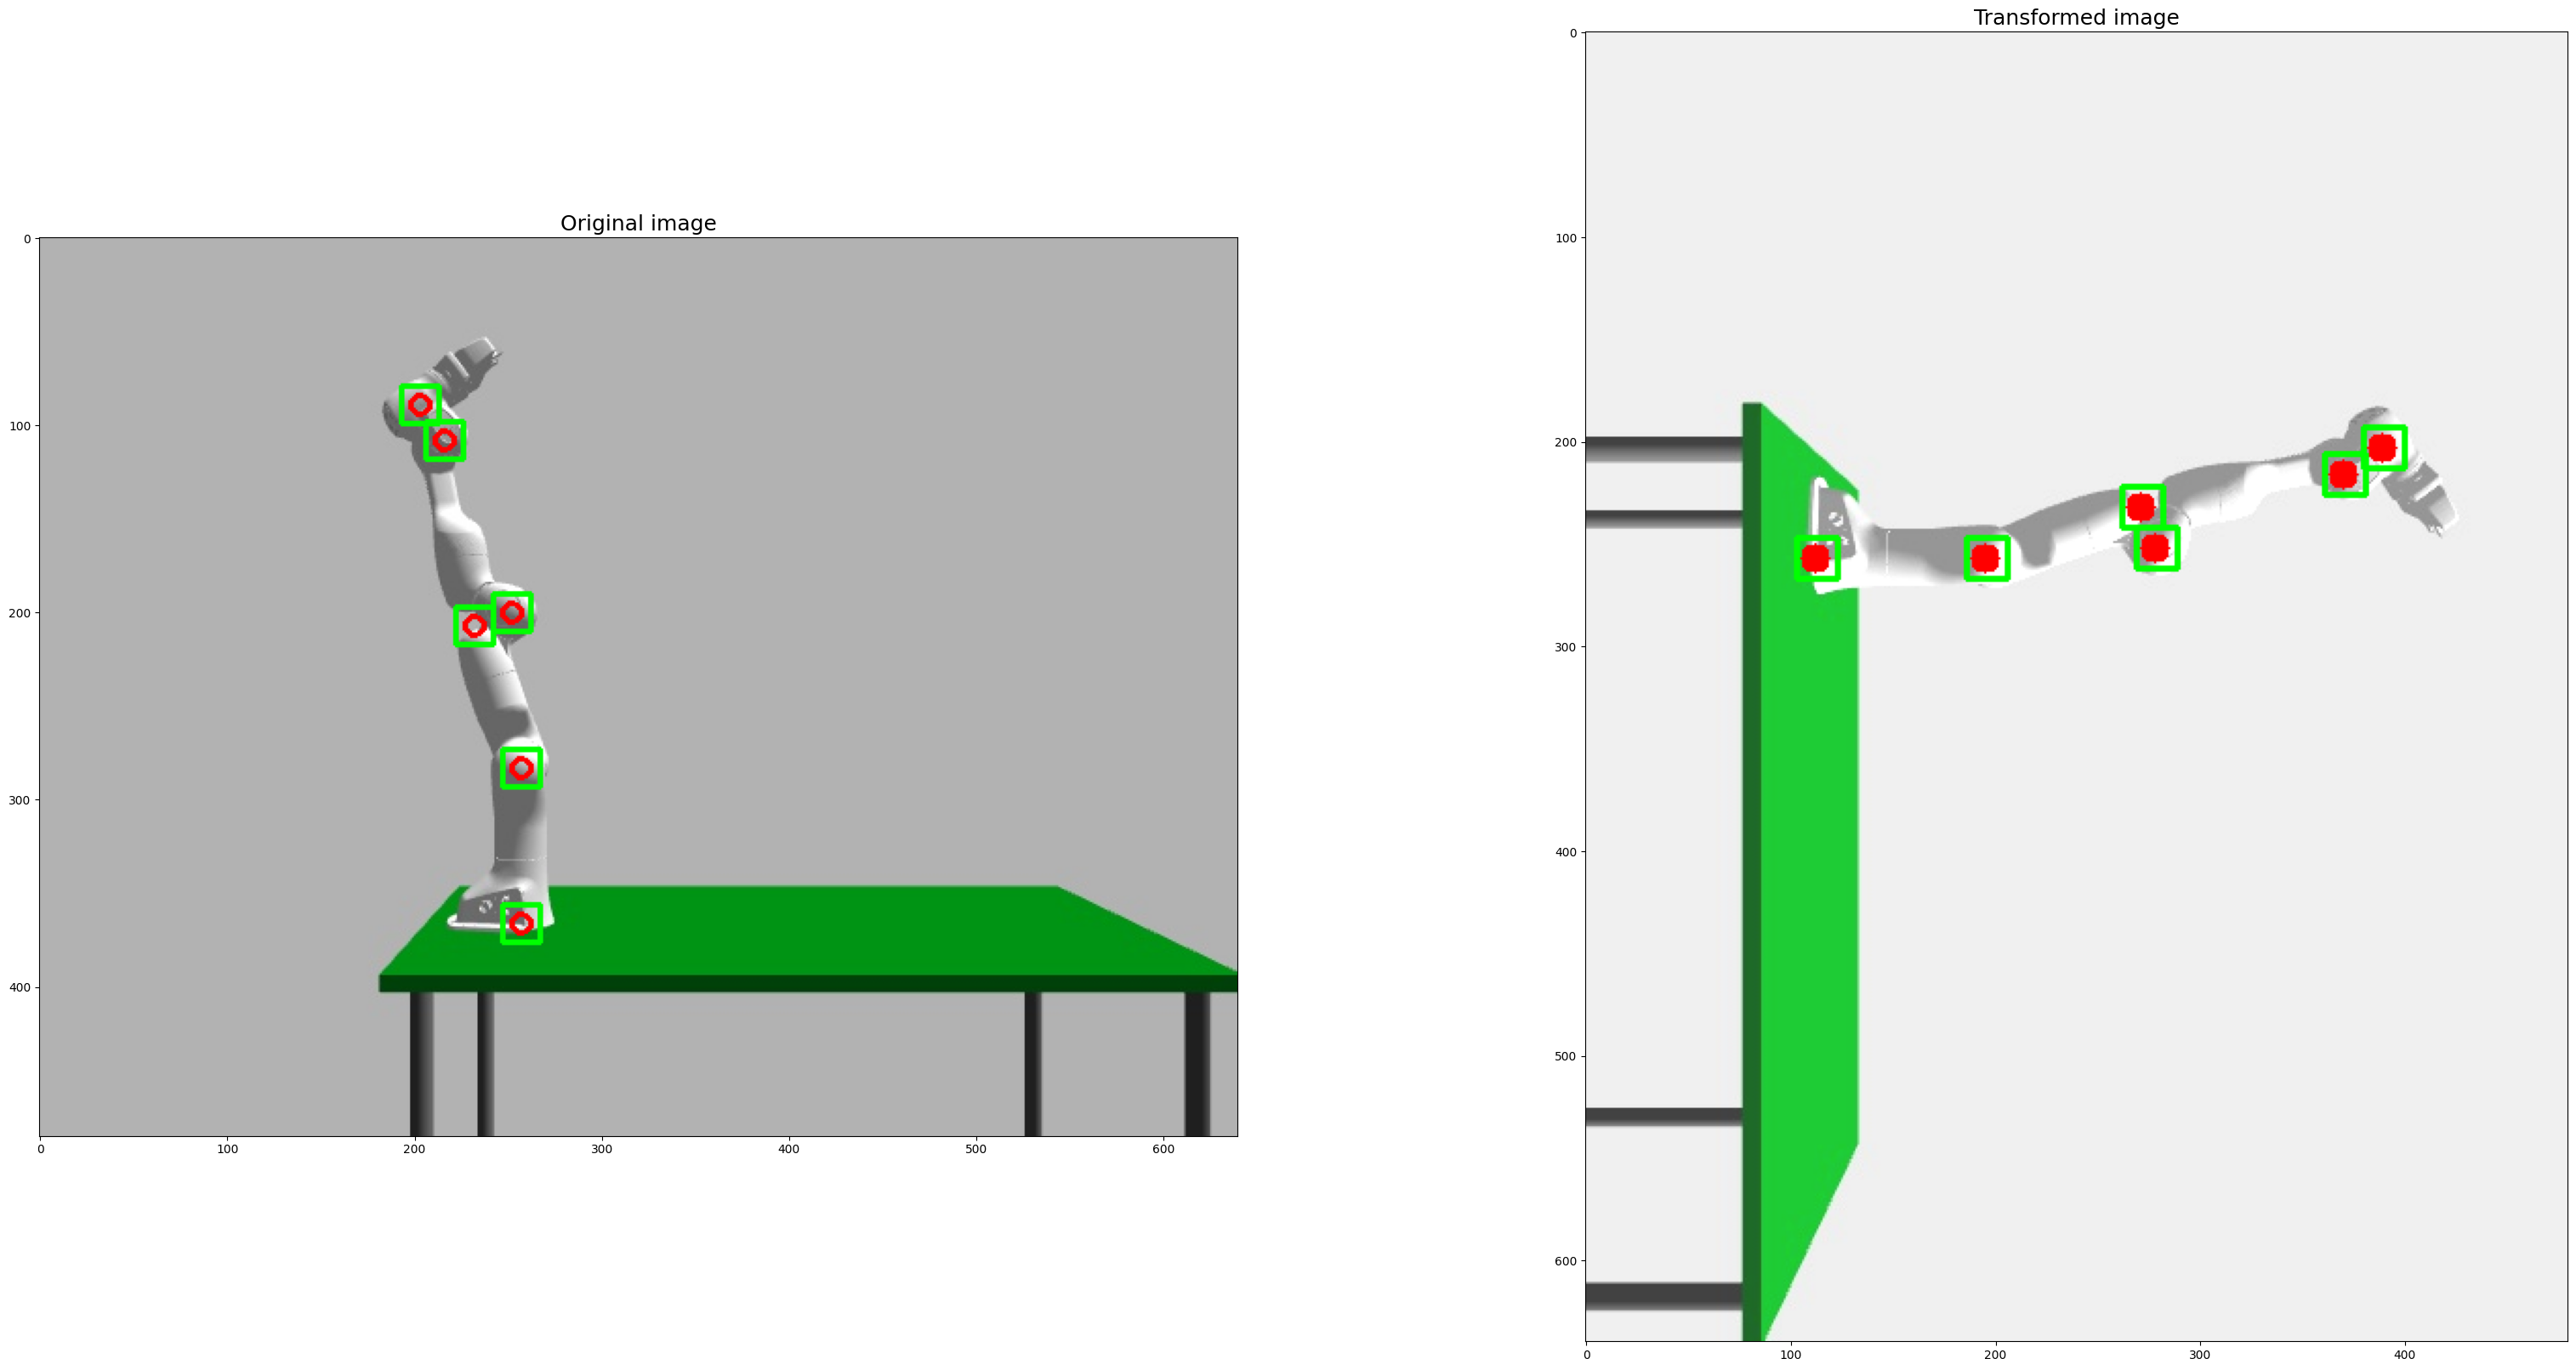

In [16]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [17]:
# def get_model(num_keypoints, weights_path=None):
    
#     anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
#     model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
#                                                                    pretrained_backbone=True,
#                                                                    num_keypoints=num_keypoints,
#                                                                    num_classes = 4, # Background is the first class, object is the second class
#                                                                    rpn_anchor_generator=anchor_generator)

#     if weights_path:
#         state_dict = torch.load(weights_path)
#         model.load_state_dict(state_dict)        
        
#     return model

In [18]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
        print("shape of x", x.shape)
        print("shape of adj", adj.shape)
        batch_size = adj.size(0)  # Assuming adj_matrix has a shape of [batch_size, 4, 4]
        if x.dim() == 2:
            # It means we have the shape [4, 3] for x, adjust accordingly
            x = x.unsqueeze(0).expand(batch_size, -1, -1)
        else:
            # We assume the shape is [4, 4, 128]
            "Do Nothing"
        out = torch.bmm(adj, x)
        out = self.fc(out)
        return out

In [19]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(
            pretrained=False, pretrained_backbone=True, num_keypoints=6, num_classes=7)
        self.graph_conv1 = GraphConv(3, 128)
        self.graph_conv2 = GraphConv(128, 3)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=6):

        detected_kps = keypoints.shape[0]
        print(labels)
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints
        
        if detected_kps == 0:
            # Placeholder: If no keypoints are detected, set to center or other static position
            default_value = torch.tensor([320, 240, 1], device=keypoints.device)
            missing_kps_tensor = torch.full((num_expected_keypoints, keypoints.shape[1]), default_value)
            return missing_kps_tensor
        
        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]

        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp

        return ordered_keypoints

    def forward(self, images, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
            return output  # This contains the losses during training
        else:
            with torch.no_grad():  # Deactivates autograd, reduces memory usage and speeds up computations
                self.keypoint_rcnn.eval()  # Set to evaluation mode
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()  # Revert to training mode
            keypoints = output[0]['keypoints'].detach().cpu().numpy()
            kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
            
            labels = output[0]['labels'].detach().cpu().numpy()                
            unique_labels = list(set(labels))
            scores = output[0]['scores'].detach().cpu().numpy()      
            
            kps = []
            kp_scores = []
            ulabels = []
            
            for label in unique_labels:
                #find the index with highest score for this label
                indices = [i for i,x in enumerate(labels) if x == label]
                scores_for_label = [scores[i] for i in indices]
                max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                kp_score_label = kp_score[max_score_index].tolist()
                # Add corresponding box, keypoint, and label to the result                
                kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])  
                ulabels.append(label)
            
            kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
            
            keypoints = torch.stack(kps)
#             print("kp before placeholder", keypoints)
            
            keypoints = self.complete_missing_keypoints(keypoints, unique_labels, num_expected_keypoints=6)            
#             print("keypoints with placeholder", keypoints)
            
            keypoints = self.graph_conv1(keypoints, adj_matrix)
            keypoints = nn.functional.relu(keypoints)
            keypoints = self.graph_conv2(keypoints, adj_matrix)

            return keypoints 


In [20]:
def custom_loss(predicted_keypoints, gt_keypoints, adj_matrix, loss_keypoint):
    mse_loss = nn.MSELoss()
    batch_size = adj_matrix.size(0)
#     gt_keypoints = gt_keypoints.repeat(batch_size, 1, 1)
    print("predicted_keypoints shape:", predicted_keypoints.shape)
    print("gt_keypoints shape:", gt_keypoints.shape)
    print("adj_matrix shape:", adj_matrix.shape)
    keypoint_loss = mse_loss(predicted_keypoints, gt_keypoints)
    #     box_loss = mse_loss(predicted_boxes, gt_boxes)
    # Compute pairwise differences
    diff = predicted_keypoints.unsqueeze(2) - gt_keypoints.unsqueeze(1)  # shape [1, 4, 4, 3]
    # Square the differences
    squared_diff = diff**2  # shape [1, 4, 4, 3]
    # Sum over the coordinate dimension (i.e., sum the squared differences for x, y, z coordinates)
    squared_diff_summed = squared_diff.sum(dim=-1)  # shape [1, 4, 4]
    # Use adjacency matrix to mask out unwanted differences and compute the graph loss
    graph_loss = torch.sum((1 - adj_matrix) * squared_diff_summed)    
#     graph_loss = torch.sum((1 - adj_matrix) * (predicted_keypoints - gt_keypoints)**2)
    
#     total_loss = keypoint_loss + 0.1 * box_loss + 0.01 * graph_loss + loss_keypoint
    total_loss = keypoint_loss + graph_loss + loss_keypoint
    
    return total_loss


In [21]:
def create_adjacency_matrix(num_keypoints):
    # Initialize a zero matrix
    adj_matrix = torch.zeros((num_keypoints, num_keypoints))
    
    # Fill the diagonal above the main diagonal with ones
    for i in range(num_keypoints - 1):
        adj_matrix[i, i + 1] = 1
        
    return adj_matrix


In [22]:
# Initialize model and optimizer
model = CombinedModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create adjacency matrix
num_keypoints = 6
adj_matrix = create_adjacency_matrix(num_keypoints)


/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the fu

In [ ]:
num_epochs = 30
batch_size = 1

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

top_5_models = []

for epoch in range(num_epochs):  # for 50 epochs
    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch  
        ground_truth_keypoints = [target['keypoints'] for target in targets]
        ground_truth_boxes = [target['boxes'] for target in targets]
        
        # Assuming you want all images to be of size [3, 640, 480]
#         desired_size = (640, 480)  

        # Resize all images to the desired size
#         resized_images = [F.resize(img, desired_size) for img in images]

        # Now stack the resized images
#         images = torch.stack(resized_images)
        images = torch.stack(images)
        ground_truth_keypoints = torch.stack(ground_truth_keypoints).squeeze()
        ground_truth_boxes = torch.stack(ground_truth_boxes)

#         Create a batched adjacency matrix with the same batch size
        batch_adj_matrix = adj_matrix.repeat(batch_size, 1, 1)
        print(batch_adj_matrix.shape)
        
        optimizer.zero_grad()
        
        # Forward pass for training
        output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
        print("Output keypoints shape", output_train.keys())
        
        #Forward pass for loss
        predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
        
        
        print("predicted keypoints", predicted_keypoints.shape)
                
        loss_keypoint = output_train['loss_keypoint']
        
        # Compute loss and backpropagate
        loss = custom_loss(predicted_keypoints, ground_truth_keypoints, 
                           adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
        
        loss.backward()
        optimizer.step()
        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            top_5_models.append((loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'best_model_{idx+1}.pth')


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 15918.89 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 15925.45 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 16143.20 files/s]

torch.Size([1, 6, 6])


Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


/home/jc-merlab/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 3])) that is different to the input size (torch.Size([1, 6, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Batch 1/931, Loss: 4523872.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 2/931, Loss: 5886270.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoc

Epoch 1/30, Batch 18/931, Loss: 3880622.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 19/931, Loss: 5257381.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
E

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 35/931, Loss: 5827902.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 36/931, Loss: 4846189.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 1/30, Batch 51/931, Loss: 4291504.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 52/931, Loss: 4436211.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Ep

Epoch 1/30, Batch 68/931, Loss: 5444325.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 69/931, Loss: 4377328.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 85/931, Loss: 4525957.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 86/931, Loss: 7070672.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 1/30, Batch 101/931, Loss: 3518741.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 102/931, Loss: 4620496.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 118/931, Loss: 4499174.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 119/931, Loss: 3410026.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/30, Batch 134/931, Loss: 5425254.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 135/931, Loss: 3853459.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 151/931, Loss: 3763289.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 152/931, Loss: 3738804.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 1/30, Batch 167/931, Loss: 1244575.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 168/931, Loss: 2370481.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 184/931, Loss: 3029389.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 185/931, Loss: 2917941.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 1/30, Batch 200/931, Loss: 3653304.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 201/931, Loss: 1690371.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 217/931, Loss: 2896038.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 218/931, Loss: 3610942.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/30, Batch 233/931, Loss: 4060145.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 234/931, Loss: 4124281.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 250/931, Loss: 1608490.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 251/931, Loss: 3495591.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 266/931, Loss: 2013937.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 267/931, Loss: 2116742.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 283/931, Loss: 2881473.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 284/931, Loss: 1182415.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 1/30, Batch 299/931, Loss: 1873576.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 300/931, Loss: 1508012.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 316/931, Loss: 940834.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 317/931, Loss: 4102190.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 332/931, Loss: 1947547.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 333/931, Loss: 3002428.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 349/931, Loss: 3439453.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 350/931, Loss: 2793456.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 365/931, Loss: 1387580.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 366/931, Loss: 2468562.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 382/931, Loss: 1903822.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 383/931, Loss: 1594679.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 398/931, Loss: 847355.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 399/931, Loss: 2795580.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 415/931, Loss: 1764272.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 416/931, Loss: 2119980.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 1/30, Batch 431/931, Loss: 2935828.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 432/931, Loss: 1980913.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 448/931, Loss: 2972721.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 449/931, Loss: 979971.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/30, Batch 464/931, Loss: 1920122.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 465/931, Loss: 2302479.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 481/931, Loss: 2896777.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 482/931, Loss: 1205102.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 1/30, Batch 497/931, Loss: 1517046.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 498/931, Loss: 2025547.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 514/931, Loss: 1549490.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 515/931, Loss: 832818.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/30, Batch 530/931, Loss: 3079596.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 531/931, Loss: 2184276.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 547/931, Loss: 1540120.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 548/931, Loss: 2389511.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 563/931, Loss: 1465556.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 564/931, Loss: 1413615.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 580/931, Loss: 815958.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 581/931, Loss: 1583427.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 1/30, Batch 596/931, Loss: 2116186.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 597/931, Loss: 4140080.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 613/931, Loss: 3087520.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 614/931, Loss: 2087482.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 629/931, Loss: 2575630.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 630/931, Loss: 2690894.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 646/931, Loss: 3158204.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 647/931, Loss: 3441063.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 662/931, Loss: 3345150.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 663/931, Loss: 2990742.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 679/931, Loss: 1170203.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 680/931, Loss: 2146983.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 1/30, Batch 695/931, Loss: 2967602.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 696/931, Loss: 2141024.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 712/931, Loss: 846126.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 713/931, Loss: 2477435.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 1/30, Batch 728/931, Loss: 1723529.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 729/931, Loss: 2516864.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 745/931, Loss: 1956481.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 746/931, Loss: 2881067.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 761/931, Loss: 2893503.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 762/931, Loss: 1936261.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 778/931, Loss: 2745377.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 779/931, Loss: 2824894.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 794/931, Loss: 2315471.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 795/931, Loss: 2215614.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 811/931, Loss: 3243610.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 812/931, Loss: 3131254.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 827/931, Loss: 1373364.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 828/931, Loss: 3408124.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 844/931, Loss: 1184932.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 845/931, Loss: 861880.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 860/931, Loss: 3595792.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 861/931, Loss: 2114278.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 877/931, Loss: 1295944.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 878/931, Loss: 723555.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 893/931, Loss: 2067843.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 894/931, Loss: 3271286.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 910/931, Loss: 1367093.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 911/931, Loss: 1039729.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 926/931, Loss: 2692604.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 927/931, Loss: 2847368.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 12/931, Loss: 3053302.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 13/931, Loss: 2308777.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 28/931, Loss: 1443888.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 29/931, Loss: 1773721.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 45/931, Loss: 2024962.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 46/931, Loss: 1836817.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 61/931, Loss: 2348431.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 62/931, Loss: 1504125.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 78/931, Loss: 1632383.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 79/931, Loss: 1032803.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 2/30, Batch 94/931, Loss: 1882919.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 95/931, Loss: 2294078.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 111/931, Loss: 1387941.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 112/931, Loss: 1659388.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 127/931, Loss: 1885713.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 128/931, Loss: 4546994.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 144/931, Loss: 2232311.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 145/931, Loss: 3514860.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 2/30, Batch 160/931, Loss: 2372684.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 161/931, Loss: 2034628.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 177/931, Loss: 1527687.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 178/931, Loss: 2408047.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 193/931, Loss: 2351875.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 194/931, Loss: 2064473.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 210/931, Loss: 3041517.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 211/931, Loss: 1519250.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 2/30, Batch 226/931, Loss: 1863492.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 227/931, Loss: 2913827.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

In [ ]:
def predict_keypoints(model_path, image_path, transform=None):
    # Load the saved model
    checkpoint = torch.load(model_path)
    model = CombinedModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image = transform(image)
    image = torch.unsqueeze(image, 0)

    # Create an adjacency matrix
    num_keypoints = 6
    adj_matrix = create_adjacency_matrix(num_keypoints).unsqueeze(0)

    # Predict keypoints
    with torch.no_grad():
        keypoints = model(image, adj_matrix=adj_matrix, train=False)

    return keypoints.cpu().numpy()

# Example usage
model_path = 'best_model_1.pth'
image_path = 'path_to_your_image.jpg'
keypoints = predict_keypoints(model_path, image_path)
print(keypoints)